# Getting the Baseline Model
## Normal Predictor and Baseline Estimators using ALS and SGD

The following notebook holds the code for how we selected, tuned, and evaluated the baseline algorithm for predicting a user's book ratings.

#### Setting up functions and importing packages

In [1]:
#import math modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import surprise modules
from surprise.prediction_algorithms.random_pred import NormalPredictor
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import evaluate, print_perf
from surprise import GridSearch
from surprise import accuracy

#import modules for calculating metrics
from collections import defaultdict
from scipy.stats import spearmanr
import time

#Graphing
%matplotlib inline

In [2]:
#Setup functions to split data for testing and training
from sklearn.model_selection import train_test_split

def pick_users_books(df, num_users, num_books):
    #Get the top num_users most prolific users
    user_counts = pd.DataFrame(df.user_id.value_counts()).sort_values('user_id', ascending=False)
    top_10K_users = list(user_counts[0:num_users].index)
    user_filtered_df = df[df.user_id.isin(top_10K_users)]
    #Get the top num_books most reviewed books by the selected users
    filtered_book_counts = pd.DataFrame(user_filtered_df.book_id.value_counts()).sort_values('book_id', ascending = False)
    top_100_filtered_books = list(filtered_book_counts[0:num_books].index)
    #Generate new filtered dataframe
    filtered_df = user_filtered_df[user_filtered_df.book_id.isin(top_100_filtered_books)]
    print("New dataframe has {} users, {} items, and a sparsity of {}".format(len(filtered_df.user_id.unique()),len(filtered_df.book_id.unique()),len(filtered_df)/(len(filtered_df.user_id.unique())*len(filtered_df.book_id.unique()))))
    #Split dataframe into training and test sets
    train, test = train_test_split(filtered_df, test_size = 0.2, random_state=42)
    return train, test

def get_all_subsets(df):
    #Generate different subsets for scaling purposes
    train_500_20, test_500_20 = pick_users_books(df, 500, 20)
    train_2000_50, test_2000_50 = pick_users_books(df, 2000, 50)
    train_10000_100, test_10000_100 = pick_users_books(df, 10000, 100)

    return train_500_20, test_500_20, train_2000_50, test_2000_50, train_10000_100, test_10000_100

In [3]:
#Set up functions to nicely display gridsearch data in a table
#Need to do results_df = pd.DataFrame.from_dict(grid_search.cv_results)

#Function for alternating least squares
def convert_grid_results_als(df):

    my_dict = df.to_dict('list')
    method = []
    reg_i = []
    reg_u = []
    n_epochs = []
    
    for x in range(len(my_dict['bsl_options'])):
        y = my_dict['bsl_options'][x]
        method.append(y['method'])
        reg_i.append(y['reg_i'])    
        reg_u.append(y['reg_u'])
        n_epochs.append(y['n_epochs'])

    del my_dict['params']
    del my_dict['scores']
    del my_dict['bsl_options']

    my_dict['method'] = method
    my_dict['reg_i'] = reg_i
    my_dict['reg_u'] = reg_u
    my_dict['n_epochs'] = n_epochs
    my_df = pd.DataFrame.from_dict(my_dict).sort_values('RMSE')

    return my_df

#Function for gradient descent
def convert_grid_results_sgd(df):

    my_dict = df.to_dict('list')
    method = []
    reg = []
    learning_rate = [] 
    n_epochs = []

    for x in range(len(my_dict['bsl_options'])):
        y = my_dict['bsl_options'][x]
        method.append(y['method'])
        reg.append(y['reg'])        
        learning_rate.append(y['learning_rate'])
        n_epochs.append(y['n_epochs'])

    del my_dict['params']
    del my_dict['scores']
    del my_dict['bsl_options']

    my_dict['method'] = method
    my_dict['reg'] = reg    
    my_dict['learning_rate'] = learning_rate
    my_dict['n_epochs'] = n_epochs
    my_df = pd.DataFrame.from_dict(my_dict).sort_values('RMSE')

    return my_df

In [4]:
# Function to calculate spearman coefficient from surPRISE predictions
def spearman(predictions):
    dict_ratings = {}
    spearmans = []
    for uid, iid, true_r, est, _ in predictions:
        if float(true_r) and float(est) and not np.isnan(true_r) and not np.isnan(est):
            if uid in dict_ratings.keys():
                dict_ratings[uid][0].append(true_r)
                dict_ratings[uid][1].append(est)
            else:
                dict_ratings[uid]=[[true_r],[est]]
    for uid in dict_ratings.keys():
        if len(dict_ratings[uid][0])>1:
            spearman = spearmanr(dict_ratings[uid][0], dict_ratings[uid][1])[0]
            if np.isnan(spearman) == False: # spearman is NaN if all true ratings are the same! exclude these
                spearmans.append(spearman)
    return np.mean(spearmans)

def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def calc_item_coverage(top_n, num_books):
    bookset = set()
    for book in top_n.keys():
        for pair in top_n[book]:
            bookset.add(pair[0])
    return float(len(bookset))/num_books

#### Loading and splitting data

In [5]:
#load ratings data
ratings = pd.read_csv('../../ratings.csv')

In [6]:
#Split data into trainint and test sets of different sizes
train_500_20, test_500_20, train_2000_50, test_2000_50, train_10000_100, test_10000_100 = get_all_subsets(ratings)

#More datasets
tr1, t1 = pick_users_books(ratings, 1000, 35)
all_1000_35 = tr1.append(t1)
tr2, t2 = pick_users_books(ratings, 5000, 70)
all_5000_70 = tr2.append(t2)
tr4, t4 = pick_users_books(ratings, 7500, 85)
all_7500_85 = tr4.append(t4)

New dataframe has 487 users, 20 items, and a sparsity of 0.44260780287474333
New dataframe has 1981 users, 50 items, and a sparsity of 0.3745583038869258
New dataframe has 9980 users, 100 items, and a sparsity of 0.2719659318637275
New dataframe has 985 users, 35 items, and a sparsity of 0.4041189267585207
New dataframe has 4980 users, 70 items, and a sparsity of 0.32403614457831326
New dataframe has 7479 users, 85 items, and a sparsity of 0.2953682074514523


#### Normal Predictor
This algorithm used Maximum Likelihood Estimation to get the mean and standard deviation of the entire dataset. It then generates random ratings from a Normal distribution with the estimated parameters.

In [7]:
#Run the Normal predictor - no gridsearch needed
algo = NormalPredictor()
reader = Reader(rating_scale=(1,5))
train = Dataset.load_from_df(train_10000_100, reader)
test = Dataset.load_from_df(test_10000_100, reader)
train.split(n_folds=3)
perf = evaluate(algo, train, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm NormalPredictor.

------------
Fold 1
RMSE: 1.3540
MAE:  1.0662
------------
Fold 2
RMSE: 1.3612
MAE:  1.0731
------------
Fold 3
RMSE: 1.3506
MAE:  1.0660
------------
------------
Mean RMSE: 1.3553
Mean MAE : 1.0684
------------
------------


The Normal predictor method is not the best since it does not learn anything about the characteristics of individual users or items.

#### Baseline Estimation

Typically, both items and users have systematic biases, meaning that some users tend to give higher or lower ratings than others, and some items receive higher ratings than others. If $\mu$ is the overall average rating within the dataset, then a baseline estimate for an unknown rating is calculated by

$\hat{r}_{ui} = \mu + b_{i} + b_{u}$

where $b_i$ is the observed deviations of item i from the average and $b_u$ is the observed deviation of user u. In order to estimate $b_u$ and $b_i$ for each user and item, one can solve the following least squares problem:

$min_{b_i, b_u} \sum_{(u,i) \in K} (r_{ui} - \mu - b_u - b_i)^2 + \lambda(\sum_u b^2_u + \sum_i b^2_i)$

The first part of the equation tries to minimize the error between the estimated and actual error, while the second regularizing term aims to avoid overfitting  by penalizing the magnitudes of the parameters. This estimation can be also done faster via alternating least squares or standard gradient descent by alternatively calculating bi and bu. Since these alternating methods sacrifice accuracy, we used grid search to reduce the errors in both.

##### Standard Gradient Descent

In the interest of time, and since this is only to establish a basic baseline, we only tested three different valyes for each hyperparameter. If this method were to be productionalized, we would need to do a more granual search for both SGD and ALS hyperparameters.

In [8]:
## UNCOMMENT BELOW TO RUN GRID SEARCH ON SGD

# #Grid search for baseline - gradient descent
# param_grid = {'bsl_options':{'method': ['sgd'], 'reg':[.02,.01,.05], 'learning_rate':[.005,.001, .01], 'n_epochs':[10,20,40]}}
# gridsearch = GridSearch(BaselineOnly, param_grid, measures=['RMSE'], verbose=0)
# reader = Reader(rating_scale=(1,5))
# train = Dataset.load_from_df(train_10000_100, reader)
# test = Dataset.load_from_df(test_10000_100, reader)
# train.split(n_folds=3)
# gridsearch.evaluate(train)
# sgd_df = convert_grid_results_sgd(pd.DataFrame.from_dict(gridsearch.cv_results))
# sgd_df.to_csv("Grid Search Results/baseline_sgd_grid_results.csv")

##### SGD GridSearch Hyperparameter Tuning Results

In [9]:
sgd_df = pd.read_csv("Grid Search Results/baseline_sgd_grid_results.csv")
sgd_df

,Unnamed: 0,RMSE,learning_rate,method,n_epochs,reg
0,4,0.895837,0.005,sgd,20,0.01
1,1,0.895893,0.005,sgd,20,0.02
2,8,0.896002,0.005,sgd,40,0.05
3,7,0.896152,0.005,sgd,20,0.05
4,2,0.896354,0.005,sgd,40,0.02
5,5,0.896522,0.005,sgd,40,0.01
6,21,0.897209,0.010,sgd,10,0.01
7,18,0.897265,0.010,sgd,10,0.02
8,25,0.897342,0.010,sgd,20,0.05
9,24,0.897525,0.010,sgd,10,0.05


#### Number of Epochs

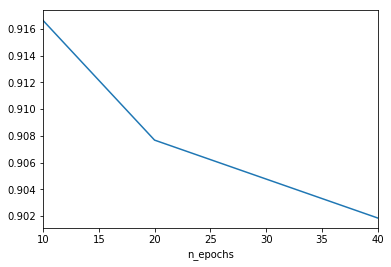

In [10]:
sgd_df.groupby('n_epochs').mean()['RMSE'].plot()

The RMSE decreases as the number of epochs increases. This could be an indication of overfitting, as typically the number of epochs suggested is less than 30. 

#### Regularization Parameter

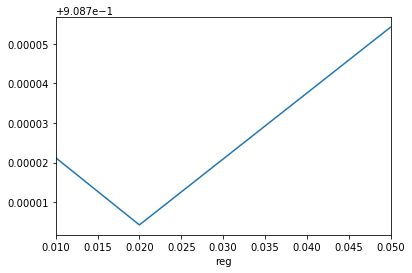

In [11]:
sgd_df.groupby('reg').mean()['RMSE'].plot()

The RMSE seems to be lowest at a regularization parameter of .02.

#### Learning Rate

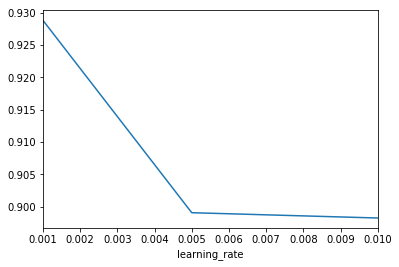

In [12]:
sgd_df.groupby('learning_rate').mean()['RMSE'].plot()

##### Alternating Least Squares

In [13]:
## UNCOMMENT THIS SECTION TO RUN GRIDSEARCH FOR ALS.

# #Grid search for baseline - alternating least squares
# param_grid = {'bsl_options':{'method': ['als'], 'reg_i':[5,10,20], 'reg_u':[10,15,20], 'n_epochs':[5,10,20]}}
# gridsearch = GridSearch(BaselineOnly, param_grid, measures=['RMSE'], verbose=0)
# reader = Reader(rating_scale=(1,5))
# train = Dataset.load_from_df(train_500_20, reader)
# test = Dataset.load_from_df(test_500_20, reader)
# train.split(n_folds=3)
# gridsearch.evaluate(train)
# als_df = convert_grid_results_als(pd.DataFrame.from_dict(gridsearch.cv_results))
# als_df.to_csv("Grid Search Results/baseline_als_grid_results.csv")

##### ALS GridSearch Hyperparameter Tuning Results

In [14]:
als_df = pd.read_csv("Grid Search Results/baseline_als_grid_results.csv")
als_df

,Unnamed: 0,RMSE,method,n_epochs,reg_i,reg_u
0,6,0.944568,als,5,20,10
1,15,0.944568,als,10,20,10
2,24,0.944568,als,20,20,10
3,3,0.944772,als,5,10,10
4,12,0.944772,als,10,10,10
5,21,0.944772,als,20,10,10
6,0,0.945057,als,5,5,10
7,9,0.945057,als,10,5,10
8,18,0.945057,als,20,5,10
9,7,0.955590,als,5,20,15


#### Number of Epochs

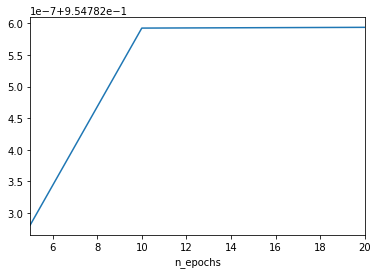

In [15]:
als_df.groupby('n_epochs').mean()['RMSE'].plot()

The RMSE seems to stop decreasing after 10 epochs.

#### Regularization Parameter for Items
The ideal parameter to minimize RMSE is around 10.

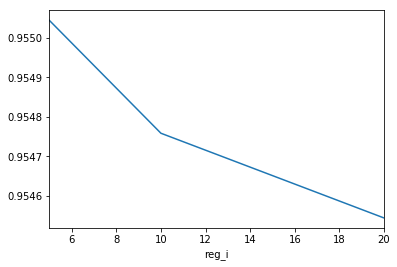

In [16]:
als_df.groupby('reg_i').mean()['RMSE'].plot()

#### Regularization Parameter for Users
A smaller reg_u seems to lead to better results

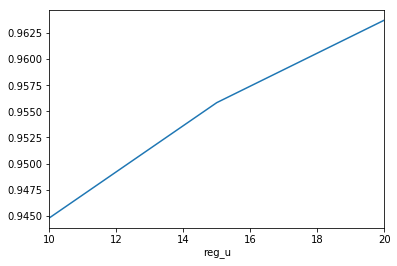

In [17]:
als_df.groupby('reg_u').mean()['RMSE'].plot()

### Choosing a Baseline Model
Using Standard Gradient Descent to estimate the bias parameters for each user and item outperforms ALS by looking at RMSE by about .05 (there is some variance in outperformance depending on the run). We therefore chose the baseline model with SGD with the following parameters 
* learning rate: .005
* regularization parameter $\lambda$: .01
* number of epochs: 20

The above model will be used to compare against our proposed neighborhood-based and model-based models. It will also be evaluated on how it scales in terms of runtime and accuracy.

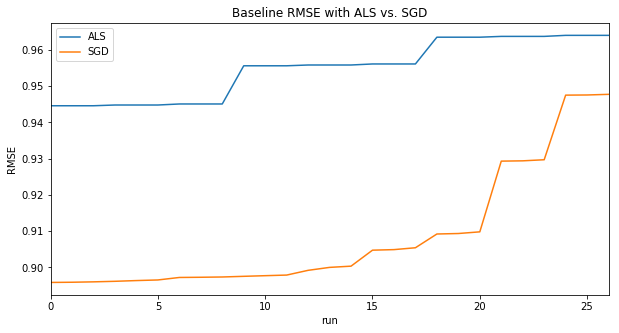

In [18]:
full_df = als_df.append(sgd_df)
full_df['run'] = full_df.index
grouped_df = full_df.groupby('method')
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
grouped_df.plot('run', 'RMSE', ax=ax)
ax.legend(['ALS','SGD'])
ax.set_ylabel('RMSE')
ax.set_title('Baseline RMSE with ALS vs. SGD')

### Scaling & Accuracy
In order to better understand how the algorithm scales with more ratings in terms of runtime and accuracy, we ran the best performing evaluation algorithm (SGD) on six different subsets of data, starting from the most prolific users and most reviewed books, and growing that set in size. 

In [19]:
#Function to run the Baseline evaluation using standard gradient descent on all data subsets for scaling
def runBaselineSGD(dataframe):
    n_ratings = len(dataframe)
    num_users = len(dataframe.user_id.unique())
    num_books = len(dataframe.book_id.unique())
    print("\nEvaluating for {} users and {} books; number of ratings: {}".format(num_users, num_books, n_ratings))
    
    #set up reader and get data from dataframe
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(dataframe[['user_id', 'book_id', 'rating']], reader)

    #Split data into training set, testing set, and the anti-test set (all the items neither in test nor train)
    trainset = data.build_full_trainset()
    testset = trainset.build_testset()
    antitestset = trainset.build_anti_testset()

    #Set up algorithm
    bsl_options = {'method': 'sgd', 'learning_rate':.005, 'n_epochs':20, 'reg':.01}
    algo = BaselineOnly(bsl_options = bsl_options)
    
    #Capture start time
    start_time = time.time()

    #Train algorithm
    algo.train(trainset)
    
    train_time = time.time() - start_time
    
    #Print training algorithm time
    print("---Training: %s seconds ---" % (train_time))

    #Capture start time - test
    start_time = time.time()
    
    #Get predictions
    predictions = algo.test(testset)
    
    test_time = time.time() - start_time
    
    #Print training algorithm time
    print("---Testing: %s seconds ---" % (test_time))

    #Evaluate accuracy measures
    rmse = accuracy.rmse(predictions, verbose=True)
    mae = accuracy.mae(predictions, verbose=True)
    accuracy.fcp(predictions, verbose=True)
    spman = spearman(predictions)
    print("SPEARMAN:  {}".format(spman))
    
    true_predictions = algo.test(antitestset)
    top_n = get_top_n(true_predictions, n=10)
    
    print("COVERAGE: {}".format(calc_item_coverage(top_n, num_books)))
    
    
    return [n_ratings, rmse, mae, spman, test_time, train_time]

In [20]:
#Combine train and test sets
all_10000_100 = train_10000_100.append(test_10000_100)
all_500_20 = train_500_20.append(test_500_20)
all_2000_50 = train_2000_50.append(test_2000_50)

running_tuples=[(all_500_20,500,20),(all_1000_35,1000,35),(all_2000_50,2000,50),(all_5000_70,5000,70),(all_7500_85,7500,85),(all_10000_100,10000,100)]

#Run SGD baseline on all subsets
results_df = [[]]
for i in running_tuples:
    results_vector = runBaselineSGD(i[0])
    results_df.append(results_vector)


Evaluating for 487 users and 20 books; number of ratings: 4311
Estimating biases using sgd...
---Training: 0.0 seconds ---
---Testing: 0.031920671463012695 seconds ---
RMSE: 0.8418
MAE:  0.6653
FCP:  0.6223


C:\Users\lohmu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3162: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\lohmu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3163: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\lohmu\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\lohmu\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\lohmu\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


SPEARMAN:  0.26246319425252296
COVERAGE: 1.0

Evaluating for 985 users and 35 books; number of ratings: 13932
Estimating biases using sgd...
---Training: 0.028217554092407227 seconds ---
---Testing: 0.0812530517578125 seconds ---
RMSE: 0.8421
MAE:  0.6590
FCP:  0.6415
SPEARMAN:  0.2909718275843386
COVERAGE: 1.0

Evaluating for 1981 users and 50 books; number of ratings: 37100
Estimating biases using sgd...
---Training: 0.19455242156982422 seconds ---
---Testing: 0.18405365943908691 seconds ---
RMSE: 0.8432
MAE:  0.6586
FCP:  0.6421
SPEARMAN:  0.2833207893730011
COVERAGE: 1.0

Evaluating for 4980 users and 70 books; number of ratings: 112959
Estimating biases using sgd...
---Training: 0.7223689556121826 seconds ---
---Testing: 0.7411463260650635 seconds ---
RMSE: 0.8463
MAE:  0.6607
FCP:  0.6425
SPEARMAN:  0.28544749851890855
COVERAGE: 0.8285714285714286

Evaluating for 7479 users and 85 books; number of ratings: 187770
Estimating biases using sgd...
---Training: 1.2289199829101562 seco

In [21]:
results_df = pd.DataFrame(results_df[1:][:], columns=['n_ratings','rmse','mae','spearman','test_time','train_time'])

### Scaling Results
The below table shows the results of accuracy and runtime as a function of the number of ratings that were trained and evaluated on. 

In [22]:
results_df

,n_ratings,rmse,mae,spearman,test_time,train_time
0,4311,0.841757,0.665276,0.262463,0.031921,0.000000
1,13932,0.842125,0.658996,0.290972,0.081253,0.028218
2,37100,0.843171,0.658559,0.283321,0.184054,0.194552
3,112959,0.846305,0.660739,0.285447,0.741146,0.722369
4,187770,0.856970,0.671885,0.290627,1.120459,1.228920
5,271422,0.858159,0.671075,0.297173,1.835596,1.781722


### Graphing Results

**RMSE**

The RMSE graph shows how the root mean squared error increases as the number of ratings in the dataset increases. Intuitively, this makes sense. As the data is getting more sparse, there is less information to accurately calculate the biases of each user and item.

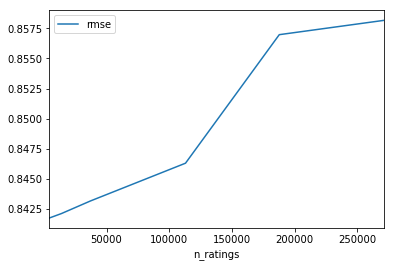

In [23]:
results_df[['n_ratings','rmse']].plot(x='n_ratings',y='rmse')

**MAE**

The Mean Absolute Error is interesting as it first decreases and then increases again with the number of ratings. Since MAE doesn't penalize large errors as much as RMSE, it could be that there are less errors in those datasets between 25000 and 75000 ratings, but that those errors are of larger magnitude.

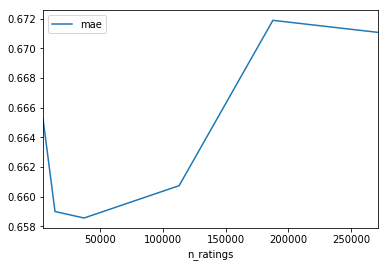

In [24]:
results_df[['n_ratings','mae']].plot(x='n_ratings',y='mae')

** Spearman Rank Correlation Coefficient **

The Spearman Coefficient mostly seems to increase with an increasing number of ratings (with one exception). This is actually a positive result for us, meaning that the algorithm is getting more accurate in ordering the suggested books for users. Even if the magnitude of the rating is becoming more errorenous, the relative order seems to be improving. 

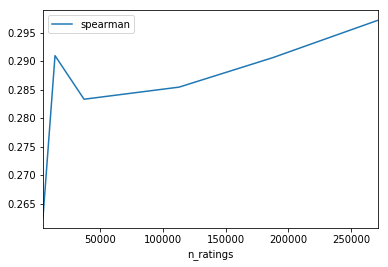

In [25]:
results_df[['n_ratings','spearman']].plot(x='n_ratings',y='spearman')

** Training and Testing Runtime **

The time it takes to test and train the datasets seems to have a linear relationship with the number of ratings. This is an encouraging result which means that we can easily extrapolate how long it would take to run the baseline algorithm for the full dataset. 

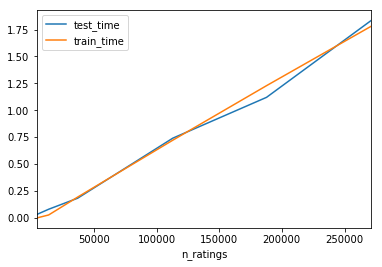

In [26]:
results_df[['n_ratings','test_time', 'train_time']].plot(x='n_ratings',y=['test_time','train_time'])

We can use the statsmodel class to calculate the intercept and coefficient for this linear relationship. We an estimate of the following:
$Time = .000007(NumRatings) - .021993$

In [27]:
import statsmodels.formula.api as sm

result = sm.ols(formula="train_time ~ n_ratings", data=results_df).fit()
print(result.params)

Intercept   -0.047921
n_ratings    0.000007
dtype: float64


In [28]:
(5976479)*.000007-0.021993

41.813359999999996

We can thus estimate that the whole dataset with 5,976,479 ratings would take about 41 to 42 seconds to train. If this were a feasible and accurate offline-calculated model, this scalability would be promising. However, the speed of the algorithm does not make up for the accuracy.

### Coverage
What percentage of books out of the total set of books does this algorithm suggest to at least one user? We used the 10K user, 100 item subset to calculate the item coverage for top-k ratings for k=5, 10, 15 and 20. 

In [29]:
#Get coverage for different values of n on the largest subset

n_ratings = len(all_10000_100)
num_users = len(all_10000_100.user_id.unique())
num_books = len(all_10000_100.book_id.unique())
    
#set up reader and get data from dataframe
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(all_10000_100[['user_id', 'book_id', 'rating']], reader)

#Split data into training set, testing set, and the anti-test set (all the items neither in test nor train)
trainset = data.build_full_trainset()
antitestset = trainset.build_anti_testset()

#Set up algorithm
bsl_options = {'method': 'sgd', 'learning_rate':.005, 'n_epochs':20, 'reg':.01}
algo = BaselineOnly(bsl_options = bsl_options)

#Train algorithm
algo.train(trainset)

#Estimate unknown ratings
true_predictions = algo.test(antitestset)

#Get top n recommendations
ns=[5,10,15,20]

for n in ns:
    top_n = get_top_n(true_predictions, n)
    print("COVERAGE FOR TOP {}: {}".format(n,calc_item_coverage(top_n, num_books)))

Estimating biases using sgd...
COVERAGE FOR TOP 5: 0.47
COVERAGE FOR TOP 10: 0.54
COVERAGE FOR TOP 15: 0.71
COVERAGE FOR TOP 20: 0.9


As expected, the coverage increased as the number of items recommended for each user increased. However, this value never reaches 1 meaning that there will be items which are not recommended to anyone. This is indicative that this algorithm may not provide great diversity or serendipity for our users.